### HW3-Practical

Name: Mohammad Javad Hezareh <br>
Student Number: 98101074

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
import math

In [2]:
#load data set
data = load_boston()
features = data['data']
target = data['target']
features_name = data['feature_names']

X = pd.DataFrame(data=features, columns=features_name)
Y = pd.DataFrame(data=target, columns=['MEDV'])
data = pd.concat([X, Y], axis=1)
data.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


## 1

In [3]:
# check missing data
data.isna().sum(axis=0)

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [4]:
# splitting data to [train] and [test] set
data_count = data.shape[0]
train_count = int(data_count * 0.8)

train_idx = np.random.choice(range(data_count), train_count, replace=False)
test_idx = filter(lambda x: x not in train_idx, range(data_count))

train_data = data.loc[train_idx,:]
test_data = data.loc[test_idx,:]
train_data.shape, test_data.shape

((404, 14), (102, 14))

## 2

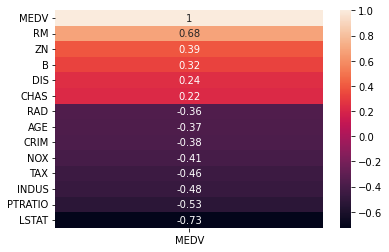

In [5]:
corr_matrix = train_data.corr()

sns.heatmap(corr_matrix[['MEDV']].sort_values(by='MEDV', ascending=False), annot=True);

In [6]:
# plotter : just plotting data based on its different features, if there is any predicted value it will plot that too
class Plotter:
    def plot(data, target, predicted=None):
        fig, axes = plt.subplots(4,4, figsize=(12,12), sharey=True)
        fig.tight_layout()

        columns = data.columns

        for i in range(13):
            sns.scatterplot(data=data, x=columns[i], y=target, ax=axes[i//4][i%4], label='original');
            if predicted is not None:
                sns.scatterplot(data=data, x=columns[i], y=predicted, ax=axes[i//4][i%4], label='predicted');

        fig.delaxes(axes[3][1])
        fig.delaxes(axes[3][2])
        fig.delaxes(axes[3][3])
        plt.legend();

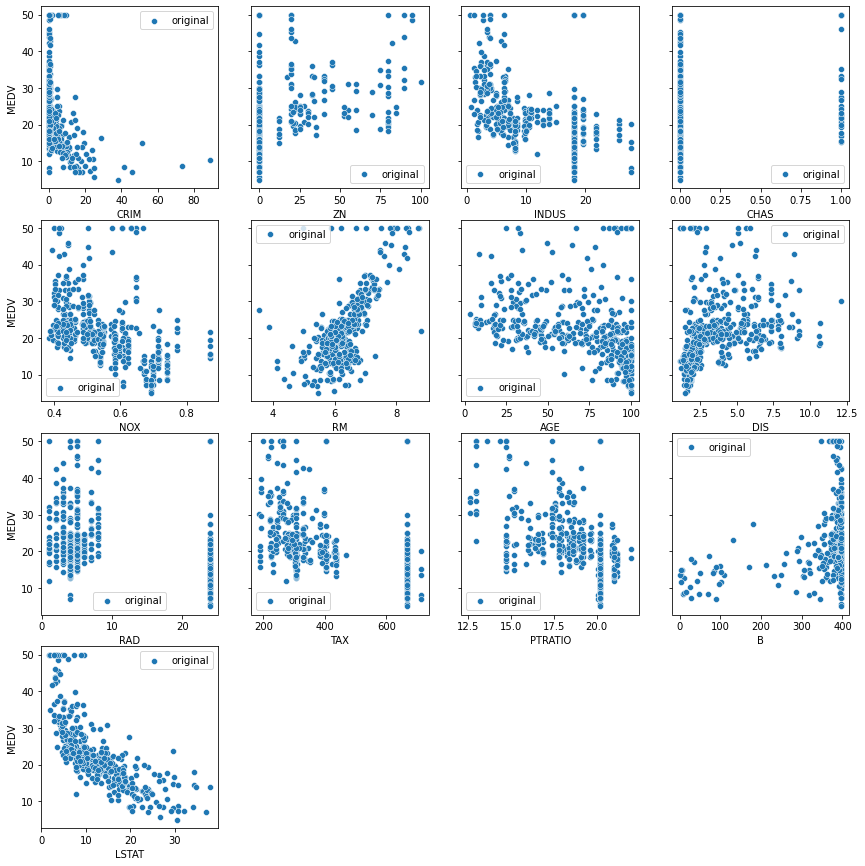

In [7]:
# plotting train_data based on its features
Plotter.plot(data=train_data, target='MEDV')

---
## General Linear Regression class

In [43]:
class LRegression:
    # method determines the bases
    def __init__(self, data, target_col, method, M):
        self.data = data
        self.target = target_col
        self.method = method
        self.M = M
        self.mu = None
        
    # degree: [for poly]-> degree of polynomials, [for gaussian]-> number of bases
    def learn_weights(self):
        X = self.__build_basis(self.data, self.M)
        Y = self.data[self.target]
        W = np.linalg.pinv(X.T @ X) @ X.T @ Y
        
        data_count = self.data.shape[0]
        self.W = W
        self.predicted = X @ W
        self.MSE = ((X @ W - Y)**2).sum()/data_count
        return W
    
    def predict(self, inputs):
        X = self.__build_basis(inputs, self.M)
        Y = inputs[[self.target]].values
        
        data_count = inputs.shape[0]
        predicted = X @ self.W
        error = ((predicted - Y)**2).sum()/data_count
        
        return (error, predicted)
    
    def __build_basis(self, data, degree):
        X = data.drop(self.target, axis=1).values
        
        methods = {
            'poly': self.__poly_bases,
            'gaussian': self.__gaussian_bases
        }
        
        return methods[self.method](X, degree)
        
    def __poly_bases(self, X, degree):
        data_count = X.shape[0]
        one = np.full((data_count, 1), 1)
        bases = np.hstack((one, X))

        power = X
        for i in range(2, degree+1):
            power = power * X
            bases = np.hstack((bases, power))
        
        return bases
    
    def __gaussian_bases(self, X, degree):
        data_count = X.shape[0]
        one = np.full((data_count, 1), 1)
        bases = np.hstack((one, X))
        
        if self.mu is None:
            mu_indices = np.random.choice(range(data_count), degree, replace=False)
            self.mu = X[mu_indices,:]
        for i in range(degree):
            mu_i = self.mu[i]
            transformed = np.reshape(list(map(lambda x: self.__gauss_base(x, mu_i, 1), X)), (-1,1))
            bases = np.hstack((bases, transformed))
        
        return bases
        
    def __gauss_base(self, x, mu, s):
        power = ((x - mu)**2).sum() / (2*s*s)
        return math.exp(-power)

## 3

optimal weights:[ 3.80932779e+01 -1.03033753e-01  6.17271976e-02  2.93663992e-03
  3.18235911e+00 -1.81013252e+01  3.28293405e+00  1.06906666e-02
 -1.47840073e+00  3.12683468e-01 -1.19783991e-02 -8.96694425e-01
  9.17040088e-03 -5.32936358e-01]
train error:22.573381237251866


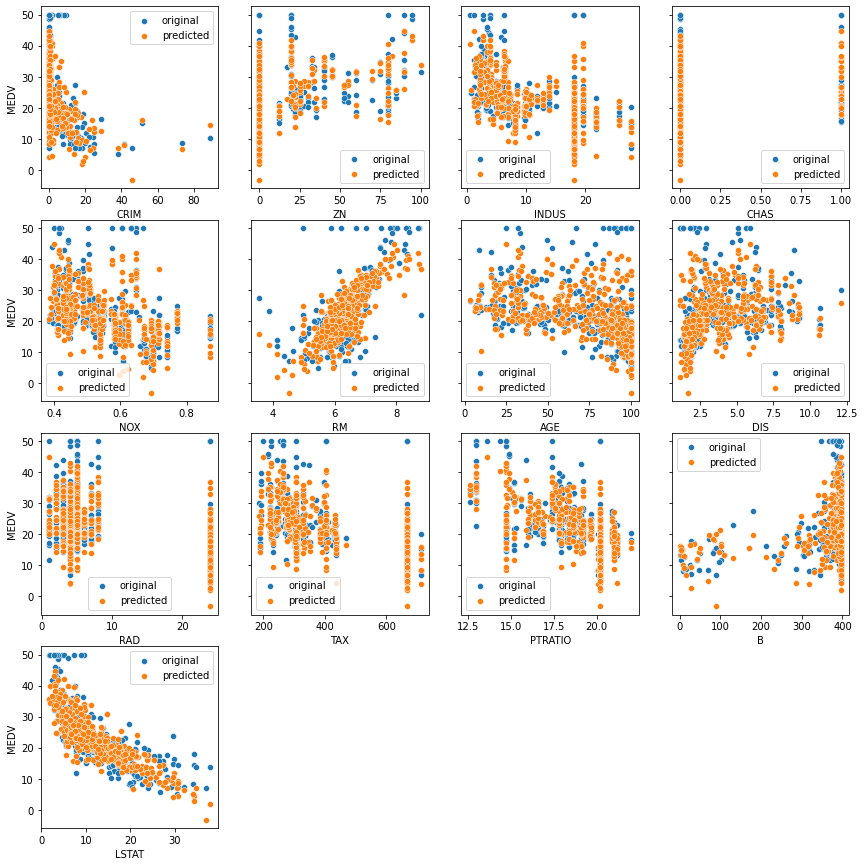

In [44]:
# model: y = w0 + w1x1 + ... + w13x13
l_reg = LRegression(train_data, 'MEDV', method='poly', M=1)
l_opt_W = l_reg.learn_weights()
l_predicted = l_reg.predicted
print(f'optimal weights:{l_opt_W}')
print(f'train error:{l_reg.MSE}')


# plotting predicted vs original
Plotter.plot(data=train_data, target='MEDV', predicted=l_predicted)

## 4

optimal weighs:[ 1.13005469e+02 -3.93921151e-01 -2.12440748e-02 -1.41858651e-01
  1.53127170e+00  3.92021526e+01 -1.57499763e+01 -1.36623055e-02
 -2.38475980e+00  4.62861902e-01 -2.29151881e-02 -3.28503099e+00
  2.55816448e-02 -1.41986735e+00  3.20400441e-03  5.29859823e-04
  5.45084956e-03  1.53127205e+00 -4.63808149e+01  1.45381300e+00
  1.35119105e-04  1.29549280e-01 -3.38414555e-03  1.16568025e-05
  7.16883102e-02 -4.29871070e-05  2.58477958e-02]
train error:14.930124088013343


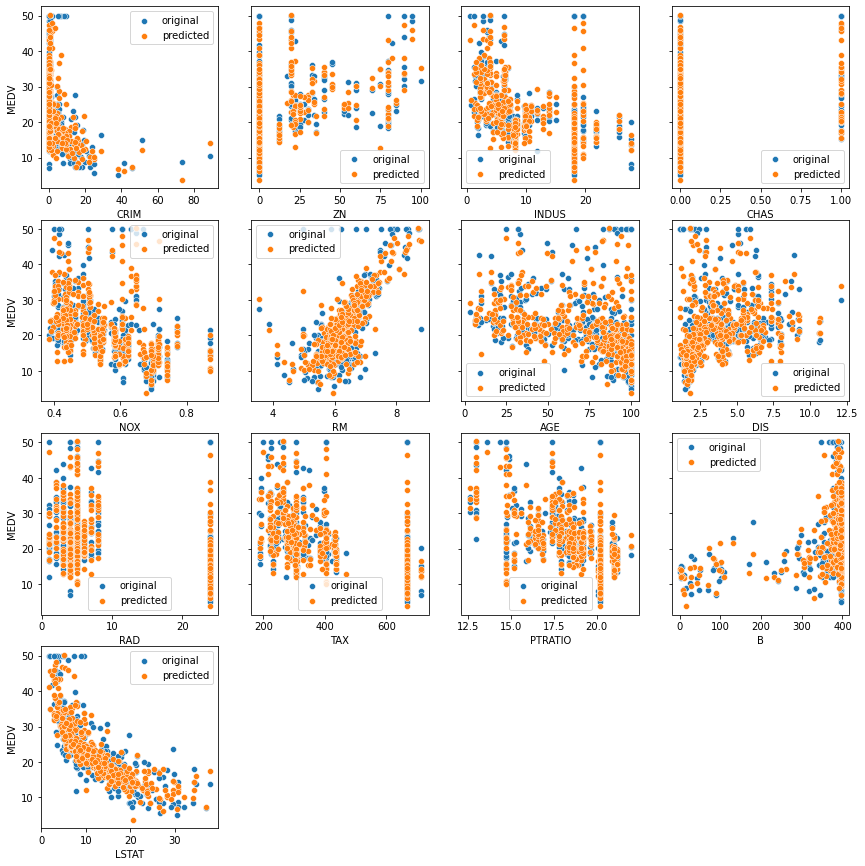

In [45]:
# model: y = w0 + w1x1 + w2x2 + ... + w13x13 + w14x1^2 + w15x2^3 + ... + w26x13^2
q_reg = LRegression(train_data, 'MEDV', method='poly', M=2)
q_opt_W = q_reg.learn_weights()
q_predicted = q_reg.predicted
print(f'optimal weighs:{q_opt_W}')
print(f'train error:{q_reg.MSE}')

# plotting predicted vs original
Plotter.plot(data=train_data, target='MEDV', predicted=q_predicted)

## 5

optimal weights:[ 3.82740922e+01 -1.02003369e-01  6.13156637e-02  3.19325701e-03
  3.09993731e+00 -1.81159233e+01  3.24159311e+00  1.16869142e-02
 -1.50706142e+00  3.09365138e-01 -1.23039830e-02 -8.65374410e-01
  9.03586800e-03 -5.47243391e-01  1.10453511e-01  2.25713341e+00
 -3.21982682e+00 -7.18761132e-01 -1.33473020e+00  2.44655475e+00
 -2.30025272e+00 -1.07946340e+01 -4.44327236e+00 -1.48537204e+00]
train error:22.171944733690196


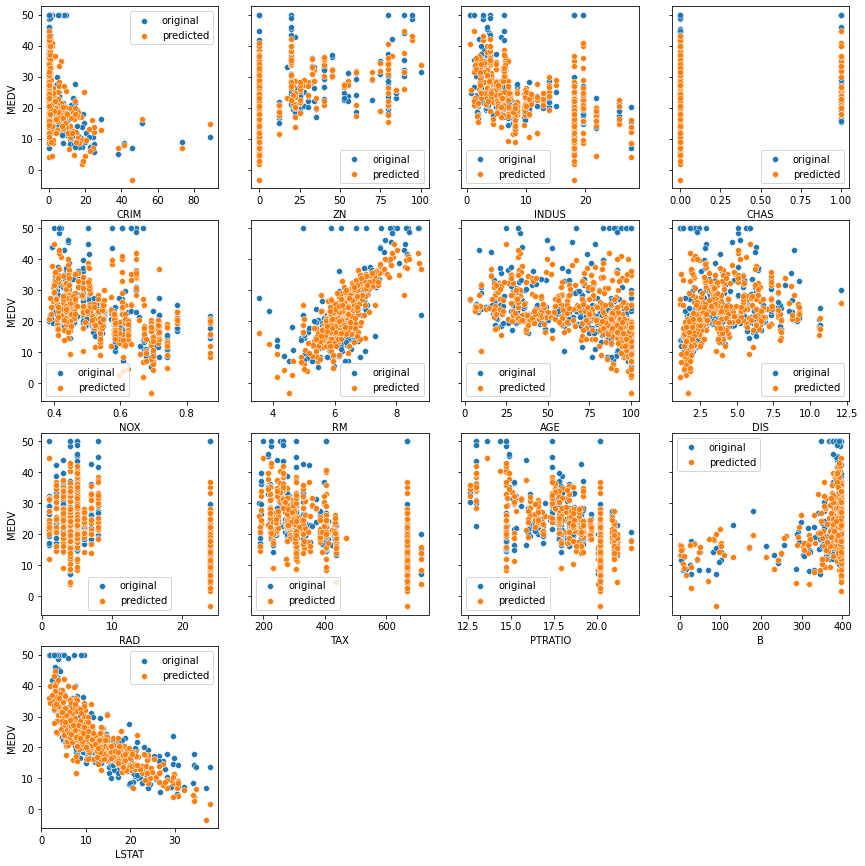

In [48]:
# model: y = w0 + w1x1 + w2x2 + ... + w13x13 + w14phi1 + w15phi2 + ... + w23phi10
g_reg = LRegression(train_data, 'MEDV', method='gaussian', M=10)
g_opt_W = g_reg.learn_weights()
g_predicted = g_reg.predicted
print(f'optimal weights:{g_opt_W}')
print(f'train error:{g_reg.MSE}')

# plotting predicted vs original
Plotter.plot(data=train_data, target='MEDV', predicted=g_predicted)

## 6

In [49]:
l_test_err, l_test_predict = l_reg.predict(test_data)
q_test_err, q_test_predict = q_reg.predict(test_data)
g_test_err, g_test_predict = g_reg.predict(test_data)

In [50]:
print(f'train_error:{l_reg.MSE}, test_error:{l_test_err}')
print(f'train_error:{q_reg.MSE}, test_error:{q_test_err}')
print(f'train_error:{g_reg.MSE}, test_error:{g_test_err}')

train_error:22.573381237251866, test_error:14174.84730337399
train_error:14.930124088013343, test_error:15764.396126737463
train_error:22.171944733690196, test_error:14213.359405561603


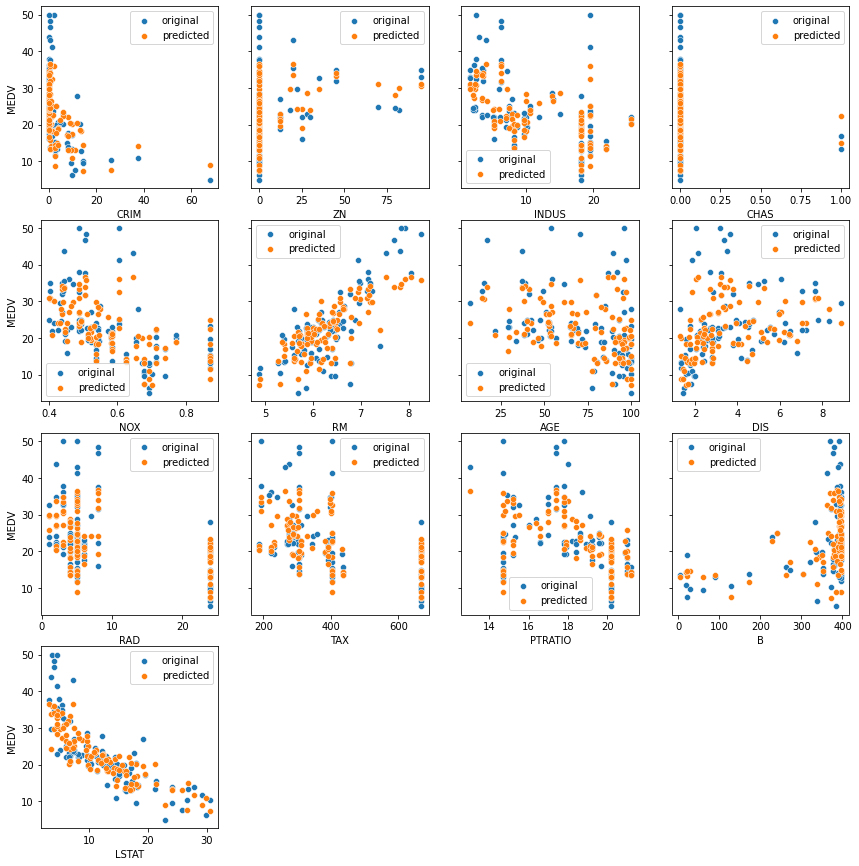

In [54]:
# first model on test set
Plotter.plot(data=test_data, target='MEDV', predicted=l_test_predict)

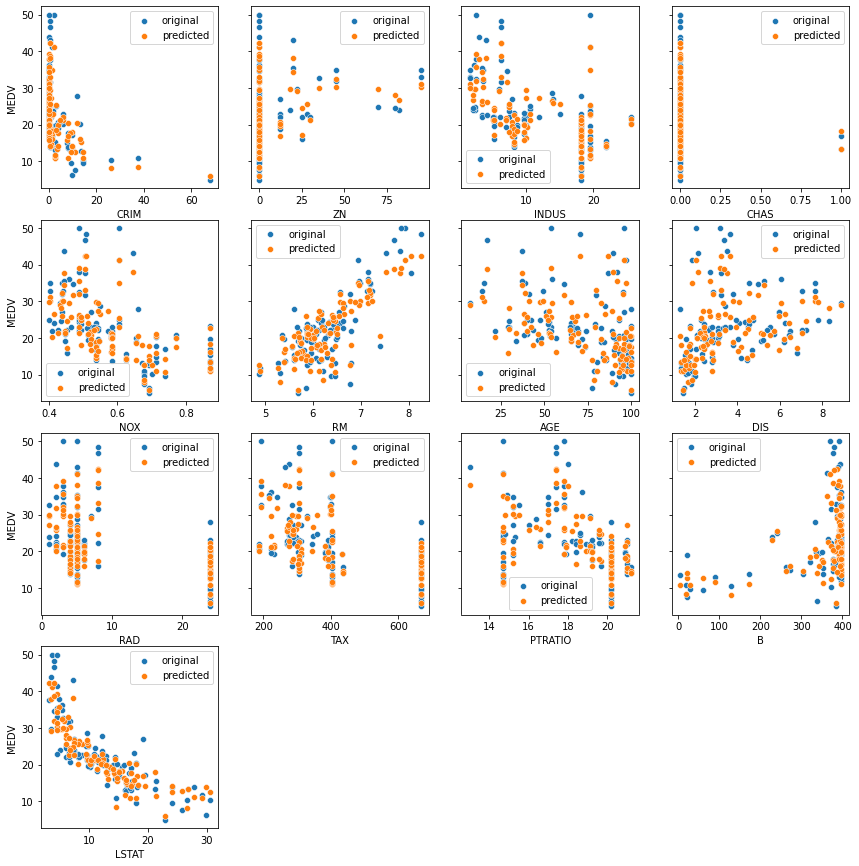

In [55]:
# second model on test set
Plotter.plot(data=test_data, target='MEDV', predicted=q_test_predict)

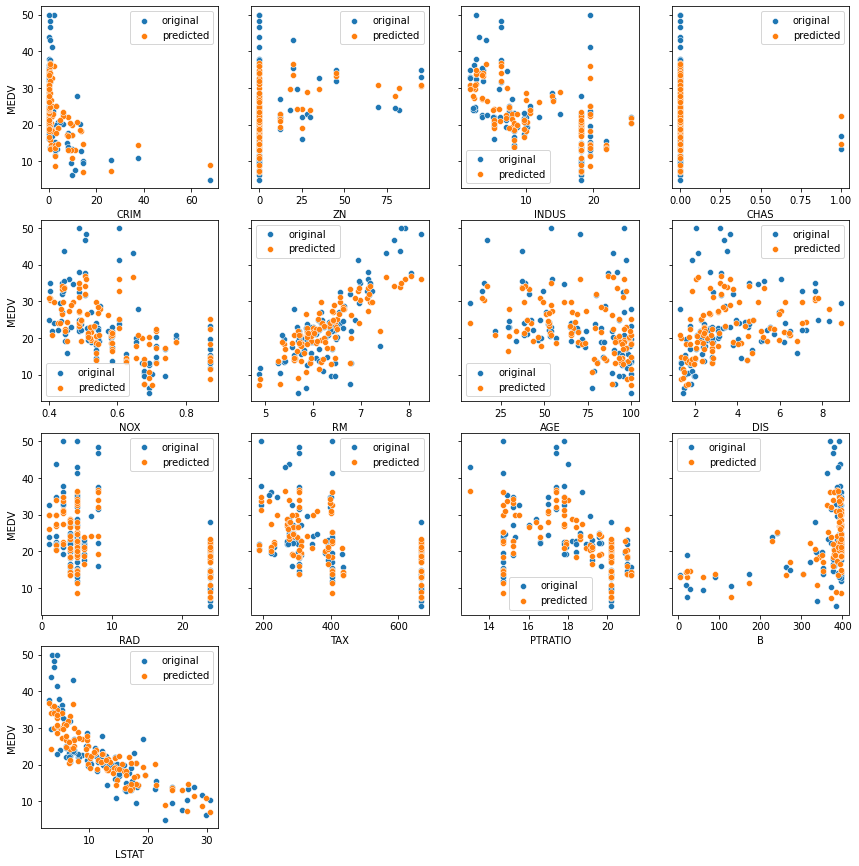

In [56]:
# third model on test set
Plotter.plot(data=test_data, target='MEDV', predicted=g_test_predict)

#### Which approach is better?
If we wanted to choose based on train_error, we would choose the second model which was using the quadratic form. But our goal is to maximize generalization to do better on unseen data. In another word, the second model has been fitted to train data and will not work well on unseen data. The first and third models (using first order and gaussian bases along with linear model respectively) have better test error than the second approach. So these approaches do better on this dataset.